In [1]:
# =================================================================================
# 1-1. Library Import 
# =================================================================================
import os
import glob
import copy
import random
import time
import io
import contextlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# fvcore (optional)
try:
    from fvcore.nn import FlopCountAnalysis
    FVCORE_AVAILABLE = True
except Exception:
    FlopCountAnalysis = None
    FVCORE_AVAILABLE = False

In [2]:
# =================================================================================
# 1-2. Define CONFIG 
# =================================================================================

CONFIG = {
    # ---------------------------
    # Reproducibility / Experiment ID
    # ---------------------------
    "seed": 42,
    "dataset_name": "WISDM",

    # ---------------------------
    # Data / Split
    # ---------------------------
    "data_dir": "C://Users/park9/CBAM_HAR/WISDM", 
    "window_size": 80,
    "step_size": 40,
    "val_ratio": 0.2,  
    "test_ratio": 0.1,  # train≈72%, val≈18%, test≈10%
    "batch_size": 128,  # dataloader

    # ---------------------------
    # Training
    # ---------------------------
    "epochs": 100,
    "learning_rate": 5e-4,
    "weight_decay": 1e-4,
    "contrast_weight": 0.25,  # total_loss = CE + contrast_weight * contrast_loss
    "scheduler_type": "cosine", # scheduler (CosineAnnealingLR)
    "scheduler_T_max": 100,  # CosineAnnealingLR(T_max=EPOCHS)

    # ---------------------------
    # Model architecture (WISDM)
    # ---------------------------
    "in_channels": 3,        # x/y/z
    "seq_len": 80,          # window length
    "n_classes": None,          # HAR classes
    "n_prototypes": None,       # prototype counts

    "embed_dim": 64,         # Conv1d -> Transformer base dim
    "reduced_dim": 32,       # if we use_dim_reduction == True
    "use_dim_reduction": False,

    "n_heads": 8,            # multi-head attention heads in CrossFormer block
    "dropout": 0.1,

    "kernel_size": 11,       # kernel sizes used in Conv1d embedding and CBAM temporal attention

    # ---------------------------
    # Feature toggles (ablations)
    # ---------------------------
    "use_cbam": True,        # CBAM
    "use_crossformer": True, # CrossFormerBlock
    "use_contrast": True,    # include contrastive prototype loss during training

    # ---------------------------
    # Contrast / Prototype behavior
    # ---------------------------
    "temperature": 0.05,     # temperature in contrastive loss

    # ---------------------------
    # Logging / Debug convenience
    # ---------------------------
    "print_every": 25,        # print every or bumped epoch
    "do_tsne": True,        # t-SNE
    "profile_model": True,  # FLOPs / Params
}

def pretty_print_config(cfg: dict):
    print("=" * 80)
    print("EXPERIMENT CONFIG")
    print("-" * 80)
    # key alignment
    max_k = max(len(k) for k in cfg.keys())
    for k in sorted(cfg.keys()):
        print(f"{k.ljust(max_k)} : {cfg[k]}")
    print("=" * 80)

In [3]:
# =================================================================================
# 1-3. Reproducibility helpers
# =================================================================================
def seed_everything(seed: int = 42):
    """
    Fix random seeds for reproducibility across random, numpy, torch (cpu & cuda).
    Also configures CuDNN for deterministic behavior.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # cudnn deterministic mode: reproducible but may be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id: int):
    """
    To make DataLoader workers deterministic.
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
# =================================================================================
# 1-4. Dataset: WISDM
# =================================================================================
def _parse_wisdm_file(path):
    """
    단일 .txt를 읽어 [subject, activity, timestamp, x, y, z] DataFrame으로 변환
    예시 라인:
      33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
    """
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(",")
            if len(parts) < 6:
                continue

            subj_str, activity, ts_str, x_str, y_str, z_str = parts[:6]
            z_str = z_str.replace(";", "").strip()

            try:
                subj = int(subj_str)
                ts   = int(ts_str)
                x    = float(x_str)
                y    = float(y_str)
                z    = float(z_str)
            except ValueError:
                # 깨진 라인 방어
                continue

            rows.append([subj, activity, ts, x, y, z])

    cols = ["subject", "activity", "timestamp", "x", "y", "z"]
    return pd.DataFrame(rows, columns=cols) if rows else pd.DataFrame(columns=cols)


def load_wisdm_dataframe(data_dir):
    """
    data_dir 아래의 *.txt 전부 파싱 후 concat
    반환: DataFrame(subject, activity, timestamp, x, y, z)
    """
    files = glob.glob(os.path.join(data_dir, "*.txt"))
    if not files:
        raise RuntimeError(f"No .txt files in {data_dir}")

    dfs = []
    for fp in files:
        df_i = _parse_wisdm_file(fp)
        if len(df_i) > 0:
            dfs.append(df_i)

    if not dfs:
        raise RuntimeError("Parsed zero valid rows from WISDM files.")

    df = pd.concat(dfs, ignore_index=True)
    df["timestamp"] = df["timestamp"].astype(np.int64)
    return df


def create_wisdm_windows(df, window_size=80, step_size=40):
    """
    (subject, activity) 그룹 내부에서만 슬라이딩 → 윈도우는 single-activity가 되도록.
    반환:
      X: (N, 3, W),  np.float32
      y: (N,),       np.int64 (라벨 인덱스)
      label_names:   list[str] (index→name 매핑)
    """
    X_list, y_list = [], []

    # 그룹 내부는 단일 활동 세그먼트라고 가정
    for (subj, act), g in df.groupby(["subject", "activity"]):
        g = g.sort_values("timestamp")
        accel = g[["x", "y", "z"]].to_numpy(dtype=np.float32)  # (L, 3)
        L = accel.shape[0]

        start = 0
        while start + window_size <= L:
            seg = accel[start:start+window_size]      # (W, 3)
            seg = np.transpose(seg, (1, 0))          # (3, W)  ← 모델 입력 포맷
            X_list.append(seg)
            y_list.append(act)
            start += step_size

    X = np.stack(X_list, axis=0)  # (N, 3, W)
    label_names = sorted(list(set(y_list)))
    label2idx = {name: i for i, name in enumerate(label_names)}
    y = np.array([label2idx[a] for a in y_list], dtype=np.int64)
    return X, y, label_names

class WISDMDataset(Dataset):
    """
    - 전체 raw txt를 읽어서
    - (subject, activity)별로 clean하게 나뉜 segment 안에서
    - 슬라이딩 윈도우(window_size/step_size)로 잘라낸 샘플을 들고 있는 Dataset
    """
    def __init__(self, data_path, window_size, step_size):
        super().__init__()
        df = load_wisdm_dataframe(data_path)

        X, y, label_names = create_wisdm_windows(
            df,
            window_size=window_size,
            step_size=step_size,
        )

        self.X = X                      # (N, 3, W)
        self.y = y                      # (N,)
        self.label_names = label_names  # 리스트[str], index -> class name

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        xi = self.X[idx]  # (C, T)
        yi = self.y[idx]  # scalar
        xi_t = torch.from_numpy(xi).float()              # (C,T)
        yi_t = torch.tensor(yi, dtype=torch.long)        # ()
        return xi_t, yi_t

In [5]:
# =================================================================================
# 2-1. CBAM1D
# =================================================================================
class ChannelAttention1D(nn.Module):
    """
    Channel attention for 1D signals.
    Input shape:  (B, C, T)
    Output shape: (B, C, T) with per-channel reweighting.
    """
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, C, T)
        avg_out = self.avg_pool(x).squeeze(-1)  # (B, C)
        max_out = self.max_pool(x).squeeze(-1)  # (B, C)

        avg_out = self.fc(avg_out)  # (B, C)
        max_out = self.fc(max_out)  # (B, C)

        out = (avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        scale = self.sigmoid(out)  # (B, C, 1)
        return x * scale  # broadcast along T


class TemporalAttention1D(nn.Module):
    """
    Temporal attention for 1D signals.
    Input shape:  (B, C, T)
    Output shape: (B, C, T) with per-timestep reweighting.

    Internally uses a conv over [avg_pool; max_pool] across channels,
    so conv input channel dim is fixed to 2.
    """
    def __init__(self, kernel_size: int = 7):
        super().__init__()

        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(
            in_channels=2,
            out_channels=1,
            kernel_size=kernel_size,
            padding=padding,
            bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)

        attn_in = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        attn_map = self.conv(attn_in)                        # (B, 1, T)
        attn_map = self.sigmoid(attn_map)
        return x * attn_map  # broadcast along C


class CBAM1D(nn.Module):
    """
    CBAM-style attention for 1D sensor sequences.
    Does channel attention -> temporal attention.

    Input / Output shape: (B, C, T)
    """
    def __init__(self, channels: int, reduction: int = 16, kernel_size: int = 7):
        super().__init__()

        self.channel_att = ChannelAttention1D(channels, reduction=reduction)
        self.temporal_att = TemporalAttention1D(kernel_size=kernel_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, C, T)
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x

In [6]:
# =================================================================================
# 2-2. CrossFormer Block (Cross-Attn between tokens and learnable prototypes)
# =================================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self,
                 dim: int,
                 n_prototypes: int = 6,
                 n_heads: int = 4,
                 mlp_ratio: float = 2.0,
                 dropout: float = 0.1,
                 initial_prototypes: torch.Tensor = None):
        """
        Args:
            dim: token embedding dim
            n_prototypes: number of learnable class prototypes
            n_heads: attention heads (must divide dim)
            mlp_ratio: FFN expansion ratio
            dropout: dropout inside MHA/MLP
            initial_prototypes: optional (n_prototypes, dim) tensor to init prototypes
        """
        super().__init__()

        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        # Learnable prototypes
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))

        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print("Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print("Prototypes initialized with Xavier Uniform.")

        # Cross-attention (tokens Q) x (prototypes K,V)
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads,
                                                dropout=dropout, batch_first=True)
        
        # Self-attention on tokens
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads,
                                               dropout=dropout, batch_first=True)
        
        # FFN
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

        # Projection for contrastive proto features
        self.proto_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )

    def forward(self,
                x: torch.Tensor,
                return_proto_features: bool = False,
                skip_cross_attention: bool = False):
        """
        Args:
            x: (B, T, C=dim)
            return_proto_features: if True, also returns pooled/proj features for contrast
            skip_cross_attention: if True, bypass cross-attn (used for proto init feature extraction)
        Returns:
            If return_proto_features:
                (x_out, proto_features, cross_attn_weights)
            else:
                x_out
        """
        B, T, C = x.shape
        attn_weights = None

        # 1) Cross-Attention (optional)
        if not skip_cross_attention:
            # normalize prototypes for stable attention keys/values
            normalized_prototypes = F.normalize(self.prototypes, dim=1, eps=1e-6)  # (P, C)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)  # (B, P, C)

            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out  # residual

        # 2) Self-Attention
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out  # residual

        # 3) FFN
        x = x + self.mlp(self.norm3(x))  # residual

        if return_proto_features:
            proto_features = x.mean(dim=1)  # (B, C)
            proto_features = self.proto_proj(proto_features)  # (B, C)
            return x, proto_features, attn_weights
        
        return x

In [7]:
# =================================================================================
# 2-3. Contrastive Prototype Loss
# =================================================================================
class ContrastivePrototypeLoss(nn.Module):
    """
    Supervised prototype contrast loss.

    For each sample embedding f_i and class prototypes P (1 per class),
    we compute a softmax over cosine similarities and apply cross-entropy
    against the ground truth label.

    Intuition:
      - Pull sample features closer to their class prototype.
      - Push them away from other class prototypes.
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.temperature = temperature

    def forward(
        self,
        features: torch.Tensor,    # (B, D)
        prototypes: torch.Tensor,  # (num_classes, D)
        labels: torch.Tensor       # (B,)
    ) -> torch.Tensor:
        """
        Args:
            features:  batch embeddings (B, D)
            prototypes: class prototype matrix (num_classes, D)
                        usually num_classes == n_prototypes
            labels:    ground-truth class indices, shape (B,), dtype long

        Returns:
            scalar loss (tensor)
        """
        # L2 normalize
        features = F.normalize(features, dim=1, eps=1e-6)
        prototypes = F.normalize(prototypes, dim=1, eps=1e-6)

        # cosine similarity
        logits = torch.matmul(features, prototypes.t()) / self.temperature  # (B, num_classes)

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)
        return loss

In [8]:
# =================================================================================
# 2-4. Final Model: embedding + (CBAM) + CrossFormer + classifier
# =================================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    """
    Sensor sequence classifier with:
      - Conv1d embedding (+ BatchNorm + GELU + Dropout)
      - Optional CBAM (channel & temporal attention)
      - Either:
          (A) CrossFormer block with learnable prototypes
        or
          (B) TransformerEncoderLayer-only self-attention fallback
      - Global average pooling over time
      - MLP classifier head
      - (Optional) contrastive prototype loss

    Args:
        in_channels:   # sensor channels (e.g. 3 for WISDM accel xyz)
        seq_len:       # sequence length (e.g. 80 for WISDM); mostly for reference / profiling
        embed_dim:     # conv embedding dim (and final feature dim if no reduction)
        reduced_dim:   # reduced dim if use_dim_reduction=True
        n_classes:     # num activity classes
        n_prototypes:  # number of learnable prototypes in CrossFormer
        n_heads:       # attention heads for CrossFormer/self-attn
        kernel_size:   # conv1d kernel size for embedding, and CBAM temporal kernel
        dropout:       # dropout rate
        temperature:   # temperature for contrastive loss
        initial_prototypes:  # tensor to init CrossFormerBlock.prototypes, or None
        use_cbam:      # if True, apply CBAM after embedding
        use_crossformer:     # if True, use CrossFormerBlock; else use vanilla self-attn block
        use_contrast:        # if True, model can return contrastive loss
        use_dim_reduction:   # if True, reduce dim before attention and restore after
    """
    def __init__(self,
                 in_channels: int = 9,
                 seq_len: int = 128,
                 embed_dim: int = 64,
                 reduced_dim: int = 32,
                 n_classes: int = 6,
                 n_prototypes: int = 6,
                 n_heads: int = 8,
                 kernel_size: int = 7,
                 dropout: float = 0.1,
                 temperature: float = 0.07,
                 initial_prototypes: torch.Tensor = None,
                 use_cbam: bool = True,
                 use_crossformer: bool = True,
                 use_contrast: bool = True,
                 use_dim_reduction: bool = False):
        super().__init__()
        
        # Save config
        self.in_channels = in_channels
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.reduced_dim = reduced_dim
        self.n_classes = n_classes
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.temperature = temperature

        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        # 1) Embedding: Conv1d -> BN -> GELU -> Dropout
        #    Input:  (B, in_channels, T)
        #    Output: (B, embed_dim, T)
        self.embedding = nn.Sequential(
            nn.Conv1d(
                in_channels,
                embed_dim,
                kernel_size=kernel_size,
                padding=(kernel_size - 1) // 2,  # "same" padding for odd kernel
            ),
            nn.BatchNorm1d(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        # 2) Optional CBAM
        #    Still (B, embed_dim, T)
        if self.use_cbam:
            self.cbam = CBAM1D(
                channels=embed_dim,
                reduction=8,
                kernel_size=kernel_size,
            )

        # 3) (Optional) Dim Reduction before attention
        #    We'll call this dimension 'working_dim'.
        #    If use_dim_reduction=False, working_dim == embed_dim.
        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        # 4) Attention backbone
        #    A) CrossFormerBlock (our prototype-based block)
        #    B) Fallback: vanilla TransformerEncoderLayer
        #    Input to these blocks: (B, T, working_dim)
        #    Output shape stays (B, T, working_dim)
        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim,
                n_prototypes=n_prototypes,
                n_heads=n_heads,
                mlp_ratio=2.0,
                dropout=dropout,
                initial_prototypes=initial_prototypes,
            )
        else:
            # TransformerEncoderLayer returns same shape (B, T, working_dim)
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim,
                nhead=n_heads,
                dim_feedforward=int(working_dim * 2),
                dropout=dropout,
                batch_first=True,
            )

        # 5) (Optional) Dim restore after attention
        #    Back to embed_dim if we reduced.
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        # 6) Temporal pooling + classifier head
        #    After attention we get (B, T, embed_dim)
        #    -> transpose to (B, embed_dim, T)
        #    -> AdaptiveAvgPool1d(1) -> (B, embed_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes),
        )

        # 7) Contrastive loss module (optional)
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)


    def forward(self,
                x: torch.Tensor,
                labels: torch.Tensor = None,
                return_contrast_loss: bool = False):
        """
        Args:
            x: (B, C_in, T)  e.g. (B, 9, 128)
            labels: (B,) long tensor with class indices [0..n_classes-1]
            return_contrast_loss: if True, we also compute contrastive loss

        Returns:
            if return_contrast_loss and use_contrast:
                (logits, contrast_loss)
            else:
                logits
        """
        # 1) Conv embedding (+CBAM)
        x = self.embedding(x)

        if self.use_cbam:
            x = self.cbam(x)

        # 2) Prepare for attention
        #    (B, embed_dim, T) -> (B, T, embed_dim)
        #    Optionally reduce dim
        x = x.transpose(1, 2).contiguous()

        if self.use_dim_reduction:
            x = self.dim_reduce(x)

        # 3) Attention backbone
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(x, return_proto_features=True,
                                                        skip_cross_attention=False)
            else:
                x = self.crossformer(x, return_proto_features=False,
                                     skip_cross_attention=False)
        else:
            x = self.self_attn(x)

        # 4) Restore dim if reduced
        if self.use_dim_reduction:
            x = self.dim_restore(x)

        # 5) Pool over time
        #    (B, T, embed_dim) -> (B, embed_dim, T) -> pool -> (B, embed_dim)
        x = x.transpose(1, 2).contiguous()
        feat_vec = self.pool(x).squeeze(-1)

        # 6) Classifier
        logits = self.classifier(feat_vec)

        # 7) Optional contrastive term
        if (
            return_contrast_loss
            and self.use_contrast
            and proto_features is not None
            and labels is not None
        ):
            contrast_loss = self.contrast_loss(
                proto_features,                # (B, dim)
                self.crossformer.prototypes,   # (n_prototypes, dim)
                labels                         # (B,)
            )
            return logits, contrast_loss

        return logits

In [9]:
# =================================================================================
# 2-5. Prototype Initialization
# =================================================================================
def get_mean_prototypes(train_full_dataset, device, config):

    temp_model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        seq_len=config['seq_len'],
        n_classes=config['n_classes'],
        n_prototypes=config['n_prototypes'],
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'], 
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        temperature=config['temperature'],
        initial_prototypes=None,
        use_cbam=config["use_cbam"],
        use_crossformer=config["use_crossformer"],
        use_contrast=False,  # 중요: 여기서는 contrast loss 안 씀
        use_dim_reduction=config['use_dim_reduction']
    ).to(device)

    temp_model.eval()

    temp_loader = DataLoader(
        train_full_dataset,
        batch_size=config["batch_size"],  # CONFIG 키 맞춤 (BATCH_SIZE -> batch_size)
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    all_features, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)

            x = temp_model.embedding(batch_x)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)

            x = x.transpose(1, 2).contiguous()

            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)

            if temp_model.use_crossformer:
                x = temp_model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=True
                )                                   # (B, T, working_dim)
            else:
                x = temp_model.self_attn(x)         # (B, T, working_dim)

            # Dim restore (if reduction was used)
            if temp_model.use_dim_reduction:
                x = temp_model.dim_restore(x)       # (B, T, embed_dim)

            x = x.transpose(1, 2).contiguous()  # (B, embed_dim, T)

            pooled_features = temp_model.pool(x).squeeze(-1)  # (B, embed_dim)

            all_features.append(pooled_features.cpu())  # (N, embed_dim)
            all_labels.append(batch_y.cpu())  # (N,)

    num_classes = config["n_classes"]
    feature_dim = config["embed_dim"]  # pooled_features의 dim과 맞춰줌

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    mean_prototypes = torch.zeros(num_classes, feature_dim, dtype=torch.float32)
    for i in range(num_classes):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            mean_prototypes[i] = torch.randn(feature_dim)
    
    return mean_prototypes.to(device)

In [10]:
# =================================================================================
# 3-1. train & evaluation
# =================================================================================
def train_epoch(model,
                dataloader,
                criterion,
                optimizer,
                device,
                use_contrast=True,
                contrast_weight=0.5):
    model.train()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            total_loss = ce_loss + contrast_weight * contrast_loss
            contrast_loss_sum  += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            total_loss  = ce_loss

        total_loss.backward()
        optimizer.step()

        total_loss_sum  += total_loss.item()
        ce_loss_sum  += ce_loss.item()

        preds = logits.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(batch_y.detach().cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum  / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum  > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model,
             dataloader,
             criterion,
             device,
             use_contrast=True,
             contrast_weight=0.5):
    model.eval()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)

            # Forward (eval 모드에서는 no_grad)
            if use_contrast and model.use_contrast and model.use_crossformer:
                logits, contrast_loss = model(
                    batch_x,
                    batch_y,
                    return_contrast_loss=True
                )
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss + contrast_weight * contrast_loss
                contrast_loss_sum += contrast_loss.item()
            else:
                logits = model(batch_x)
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss

            total_loss_sum  += total_loss.item()
            ce_loss_sum += ce_loss.item()

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

        torch.cuda.synchronize()

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, acc, f1, all_preds, all_labels, avg_ce_loss, avg_contrast_loss

In [11]:
# =================================================================================
# 4-1. Confusion Matrix & t-SNE
# =================================================================================

def plot_classification_results(y_true, y_pred, label_names, save_path=None):
    """
    Confusion Matrix 시각화 + classification report 출력.

    y_true: (N,) true labels (ints)
    y_pred: (N,) predicted labels (ints)
    label_names: list[str], len == num_classes, index -> readable label
    """
    print("\n" + "=" * 80)
    print("Classification Report")
    print("=" * 80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=label_names,
            digits=4,
            zero_division=0,
        )
    )

    # 정규화된 Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=label_names,
        yticklabels=label_names,
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('')
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()
    plt.close()


def _extract_featvec_before_classifier(model, xb, device):
    """
    모델의 forward 흐름을 따라가되,
    classifier 직전의 feature vector(feat_vec)를 추출해 반환.
    - xb: (B, C_in, T) on CPU
    returns: (B, embed_dim) on CPU (grad 없음)
    """
    xb = xb.to(device)

    # 1. Embedding (+CBAM)
    x = model.embedding(xb)                  # (B, embed_dim, T)
    if model.use_cbam:
        x = model.cbam(x)                    # (B, embed_dim, T)

    # 2. (B, C, T) -> (B, T, C)
    x = x.transpose(1, 2).contiguous()       # (B, T, embed_dim)

    # 3. Dim reduction (optional)
    if model.use_dim_reduction:
        x = model.dim_reduce(x)              # (B, T, reduced_dim)

    # 4. Attention backbone
    if model.use_crossformer:
        # 실제 inference 경로에 맞게 skip_cross_attention=False 사용
        x = model.crossformer(
            x,
            return_proto_features=False,
            skip_cross_attention=False
        )                                    # (B, T, working_dim)
    else:
        x = model.self_attn(x)               # (B, T, working_dim)

    # 5. Dim restore (optional)
    if model.use_dim_reduction:
        x = model.dim_restore(x)             # (B, T, embed_dim)

    # 6. Pooling과 동일한 처리
    x = x.transpose(1, 2).contiguous()       # (B, embed_dim, T)
    feat_vec = model.pool(x).squeeze(-1)     # (B, embed_dim)

    return feat_vec.detach().cpu()           # CPU tensor, no grad


def visualize_tsne(model, dataloader, device, label_names, save_path=None, max_points=2000):
    """
    모델의 classifier 직전 feature space를 t-SNE로 투영해서 2D 시각화.

    model: 학습 완료된 모델
    dataloader: 보통 val_loader 또는 test_loader 추천
    label_names: list[str] for legend
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="t-SNE(feat)"):
            feat_vec = _extract_featvec_before_classifier(model, xb, device)  # (B, D) on CPU
            all_features.append(feat_vec.numpy())
            all_labels.append(yb.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)  # (N, D)
    all_labels = np.concatenate(all_labels, axis=0)      # (N,)

    # 다운샘플 (max_points 이상이면 랜덤 서브셋)
    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]  # (M, D)
    y_sel = all_labels[idx]    # (M,)

    # t-SNE perplexity 안전하게 설정
    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)  # (M, 2)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [label_names[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=sns.color_palette("hsv", n_colors=len(label_names)),
        legend="full",
        alpha=0.8,
    )
    plt.title("t-SNE of model embeddings", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        title="Activity",
        loc="upper right",
        fontsize=6,
        title_fontsize=7,
        labelspacing=0.2,
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")

    plt.show()
    plt.close()


def visualize_tsne_raw(dataloader, device, label_names, save_path=None, max_points=2000):
    """
    모델 전처리 전의 raw window (C x T)를 flatten해서 t-SNE 투영.

    dataloader: 보통 val_loader나 test_loader
    label_names: list[str] for legend
    """
    all_raw = []
    all_labels = []

    for xb, yb in tqdm(dataloader, desc="t-SNE(raw)"):
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    # 다운샘플
    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]    # (M, C, T)
    y_sel = all_labels[idx] # (M,)

    # flatten → (M, C*T)
    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [label_names[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=sns.color_palette("hsv", n_colors=len(label_names)),
        legend="full",
        alpha=0.8,
    )
    plt.title("t-SNE of raw input windows", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        title="Activity",
        loc="upper right",
        fontsize=6,
        title_fontsize=7,
        labelspacing=0.2,
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")

    plt.show()
    plt.close()

In [12]:
# =================================================================================
# 4-2. Model profiling: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model,
                  sample_input: torch.Tensor,
                  device: torch.device,
                  warmup: int = 10,
                  iters: int = 50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M 단위)
      - FLOPs per sample (M 단위, fvcore 있으면)
      - 평균 추론 시간 (ms / sample)

    fvcore가 stdout/stderr에 시끄럽게 프린트하는 걸 다 먹어버린다.
    """

    model = model.to(device)
    model.eval()

    # -------------------------------------------------
    # 1) 파라미터 수
    # -------------------------------------------------
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6  # million params

    # -------------------------------------------------
    # 2) FLOPs 측정 (fvcore 사용 가능할 때만)
    #    - 모든 stdout/stderr을 임시 버퍼로 리다이렉트해서
    #      "Unsupported operator ..." 같은 중얼거림을 완전히 감춘다.
    # -------------------------------------------------
    flops_m = None
    if "FVCORE_AVAILABLE" in globals() and FVCORE_AVAILABLE and FlopCountAnalysis is not None:
        try:
            with torch.no_grad():
                fake_out = io.StringIO()
                fake_err = io.StringIO()
                with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                    flops = FlopCountAnalysis(model, (sample_input.to(device),))
                    total_flops = flops.total()
            flops_m = total_flops / 1e6  # to millions
        except Exception:
            flops_m = None
    else:
        flops_m = None

    # -------------------------------------------------
    # 3) 추론 시간 측정
    # -------------------------------------------------
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }



def print_model_profile(stats_dict):
    print("=" * 80)
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=" * 80)

DataSet : WISDM
Device  : cuda
EXPERIMENT CONFIG
--------------------------------------------------------------------------------
batch_size        : 128
contrast_weight   : 0.25
data_dir          : C://Users/park9/CBAM_HAR/WISDM
dataset_name      : WISDM
do_tsne           : True
dropout           : 0.1
embed_dim         : 64
epochs            : 100
in_channels       : 3
kernel_size       : 11
learning_rate     : 0.0005
n_classes         : 6
n_heads           : 8
n_prototypes      : 6
print_every       : 25
profile_model     : True
reduced_dim       : 32
scheduler_T_max   : 100
scheduler_type    : cosine
seed              : 42
seq_len           : 80
step_size         : 40
temperature       : 0.05
test_ratio        : 0.1
use_cbam          : True
use_contrast      : True
use_crossformer   : True
use_dim_reduction : False
val_ratio         : 0.2
weight_decay      : 0.0001
window_size       : 80
Prototypes initialized with Xavier Uniform.


Prototype Init: 100%|██████████| 128/128 [00:00<00:00, 230.76it/s]


Prototypes initialized with calculated mean features.
Parameters: 66,844


[025/100]
  train | total=0.0308  ce=0.0243  ct=0.0260  acc=0.9931  f1=0.9931
  val   | total=0.0654  ce=0.0524  ct=0.0519  acc=0.9879  f1=0.9878


[050/100]
  train | total=0.0106  ce=0.0084  ct=0.0090  acc=0.9977  f1=0.9977
  val   | total=0.0593  ce=0.0478  ct=0.0463  acc=0.9884  f1=0.9884


[075/100]
  train | total=0.0063  ce=0.0049  ct=0.0054  acc=0.9987  f1=0.9987
  val   | total=0.0515  ce=0.0414  ct=0.0402  acc=0.9908  f1=0.9908


[100/100]
  train | total=0.0041  ce=0.0032  ct=0.0037  acc=0.9993  f1=0.9993
  val   | total=0.0515  ce=0.0414  ct=0.0404  acc=0.9908  f1=0.9908

[Training Complete!]
  Best Val Acc: 0.9919 @ epoch 87
  Test (best val ckpt): acc=0.9930, f1=0.9930, total_loss=0.0395, ce=0.0315, ct=0.0317
Parameters      : 0.0668 M
FLOPs / sample : 2.341 M
Infer Time     : 1.76 ms/sample

Classification Report
              precision    recall  f1-score   support

  Downstairs     0.9879    0.9683    0.9780       504
     Jogging     0.9963    0.9951    0.9957      1643
     Sitting     0.9966    1.0000    0.9983       294
    Standing     1.0000    0.9956    0.9978       229
    Upstairs     0.9762    0.9824    0.9793       625
     Walking     0.9954    0.9991    0.9972      2143

    accuracy                         0.9930      5438
   macro avg     0.9921    0.9901    0.9910      5438
weighted avg     0.9930    0.9930    0.9930      5438



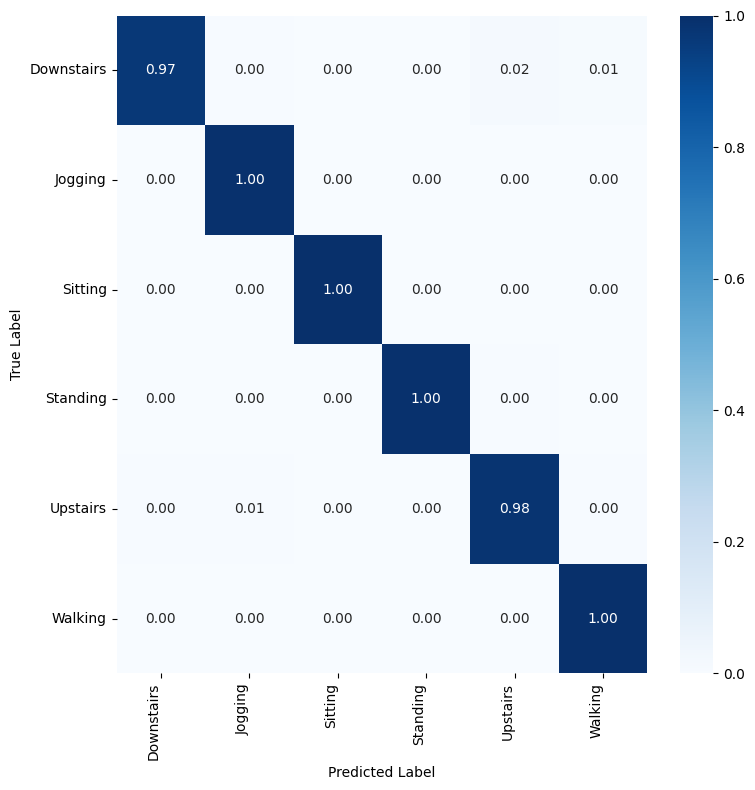

t-SNE(feat): 100%|██████████| 43/43 [00:00<00:00, 269.38it/s]


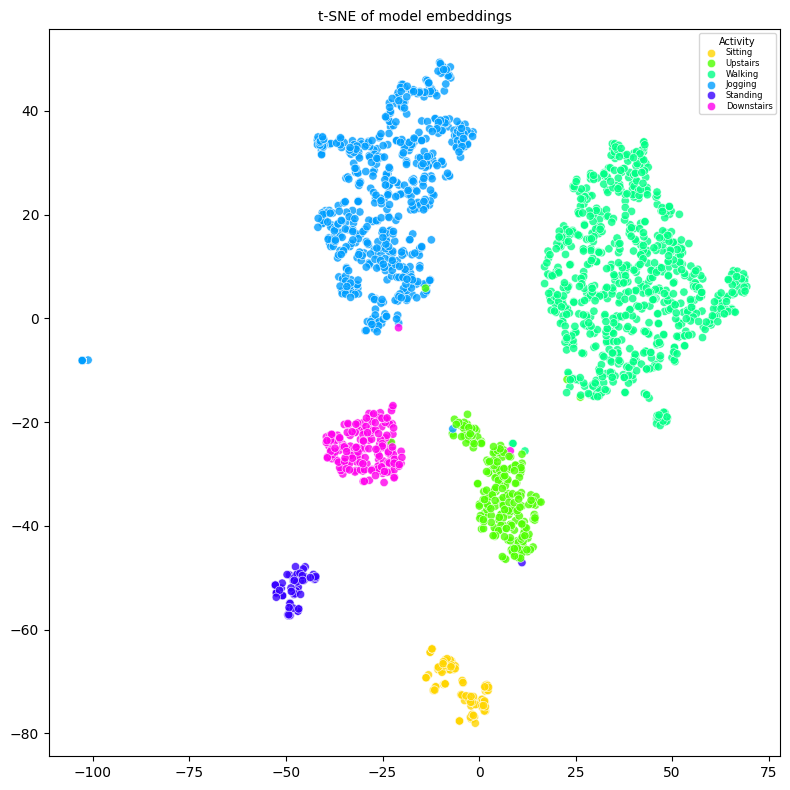

t-SNE(raw): 100%|██████████| 43/43 [00:00<00:00, 1168.57it/s]


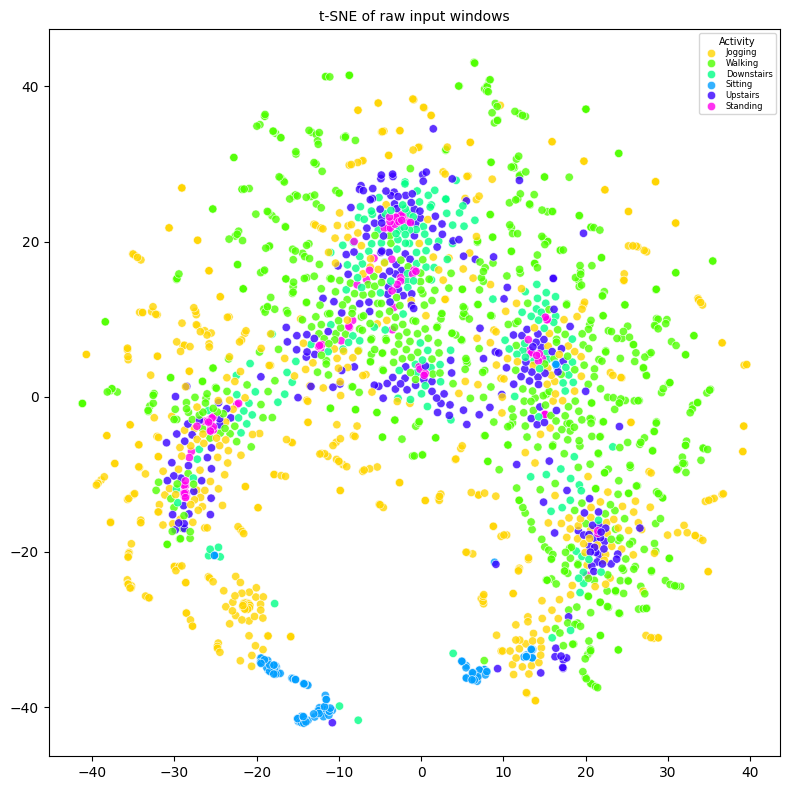

In [13]:
# =====================================================================
# 5. Main
# =====================================================================
def main():
    # -----------------------------
    # Device / SEED
    # -----------------------------
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed_everything(CONFIG["seed"])

    # -----------------------------
    # Load full WISDM dataset
    #   (WISDMDataset 내부에서:
    #    - txt 읽고
    #    - (subject, activity)별로 정렬 후 슬라이딩 윈도우
    #    - self.X: (N, C, T)
    #    - self.y: (N,)
    #    - self.label_names: list[str])
    # -----------------------------
    dataset_full = WISDMDataset(
        data_path=CONFIG["data_dir"],
        window_size=CONFIG["window_size"],
        step_size=CONFIG["step_size"],
    )

    # -----------------------------
    # Update CONFIG based on data
    # -----------------------------
    CONFIG["in_channels"]   = dataset_full.X.shape[1]          # e.g. 3 for WISDM accel x,y,z
    CONFIG["seq_len"]       = dataset_full.X.shape[2]          # e.g. 80
    CONFIG["n_classes"]     = len(dataset_full.label_names)
    CONFIG["n_prototypes"]  = len(dataset_full.label_names)    # prototype per class

    # 이제 CONFIG가 완성됐으니 출력
    print("=" * 80)
    print("DataSet : WISDM")
    print(f"Device  : {DEVICE}")
    print("=" * 80)
    pretty_print_config(CONFIG)

    # -----------------------------
    # Split train / val / test
    # ex) 60/20/20 split for baseline
    # -----------------------------
    N = len(dataset_full)
    n_train = int(0.6 * N)
    n_val   = int(0.2 * N)
    n_test  = N - n_train - n_val

    train_dataset, val_dataset, test_dataset = random_split(
        dataset_full,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(CONFIG["seed"]),
    )

    # -----------------------------
    # DataLoader
    # -----------------------------
    g = torch.Generator().manual_seed(CONFIG["seed"])

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        num_workers=0,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    # -----------------------------
    # Initialize Prototypes
    # -----------------------------
    initial_prototypes = get_mean_prototypes(
        train_dataset,
        DEVICE,
        CONFIG
    )

    # -----------------------------
    # Create Model
    # -----------------------------
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=CONFIG["in_channels"],
        seq_len=CONFIG["seq_len"],
        embed_dim=CONFIG["embed_dim"],
        reduced_dim=CONFIG["reduced_dim"],
        n_classes=CONFIG["n_classes"],
        n_prototypes=CONFIG["n_prototypes"],
        n_heads=CONFIG["n_heads"],
        kernel_size=CONFIG["kernel_size"],
        dropout=CONFIG["dropout"],
        temperature=CONFIG["temperature"],
        initial_prototypes=initial_prototypes,  # mean proto init
        use_cbam=CONFIG["use_cbam"],
        use_crossformer=CONFIG["use_crossformer"],
        use_contrast=CONFIG["use_contrast"],
        use_dim_reduction=CONFIG["use_dim_reduction"],
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")
    print("=" * 80)

    # -----------------------------
    # optimizer / scheduler / criterion
    # -----------------------------
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG["scheduler_T_max"],
    )

    # -----------------------------
    # Train Loop
    # -----------------------------
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    history = []
    
    for epoch in range(CONFIG["epochs"]):
        # 1) train
        train_total, train_ce, train_ct, train_acc, train_f1 = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # 2) val  
        val_total, val_acc, val_f1, _, _, val_ce, val_ct = evaluate(
            model,
            val_loader,
            criterion,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # 3) scheduler step
        if scheduler is not None:
            scheduler.step()

        # 4) 기록
        history.append({
            "epoch": epoch + 1,
            "train_total": train_total,
            "train_ce": train_ce,
            "train_ct": train_ct,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_total": val_total,
            "val_ce": val_ce,
            "val_ct": val_ct,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # 5) best ckpt 추적 (val acc 기준)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        # 6) 로깅 (print_every 기준)
        if (epoch + 1) % CONFIG["print_every"] == 0:
            ep_now   = epoch + 1
            ep_total = CONFIG["epochs"]

            print(f"[{ep_now:03d}/{ep_total:03d}]")
            print(
                "  train | "
                f"total={train_total:.4f}  "
                f"ce={train_ce:.4f}  "
                f"ct={train_ct:.4f}  "
                f"acc={train_acc:.4f}  "
                f"f1={train_f1:.4f}"
            )
            print(
                "  val   | "
                f"total={val_total:.4f}  "
                f"ce={val_ce:.4f}  "
                f"ct={val_ct:.4f}  "
                f"acc={val_acc:.4f}  "
                f"f1={val_f1:.4f}"
            )

    # -------------------------------------------------
    # Load Best ckpt 
    # -------------------------------------------------
    assert best_state is not None, "Training loop didn't save any best_state."
    model.load_state_dict(best_state)

    # -------------------------------------------------
    # Final Test by Best ckpt
    # -------------------------------------------------
    test_total, test_acc, test_f1, test_preds, test_labels, test_ce, test_ct = evaluate(
        model,
        test_loader,
        criterion,
        DEVICE,
        use_contrast=CONFIG["use_contrast"],
        contrast_weight=CONFIG["contrast_weight"],
    )

    print("=" * 80)
    print("\n[Training Complete!]")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(
        f"  Test (best val ckpt): "
        f"acc={test_acc:.4f}, f1={test_f1:.4f}, "
        f"total_loss={test_total:.4f}, ce={test_ce:.4f}, ct={test_ct:.4f}"
    )
    
    # -----------------------------
    # model profile
    # -----------------------------
    if CONFIG["profile_model"]:
        dummy_input = torch.randn(
            1,
            CONFIG["in_channels"],
            CONFIG["seq_len"],
        )
        stats = profile_model(model, dummy_input, DEVICE)
        print_model_profile(stats)

    # -----------------------------
    # Visualize CM, t-SNE
    # -----------------------------
    plot_classification_results(
        test_labels,
        test_preds,
        label_names=dataset_full.label_names,
        save_path="confusion_matrix.png"
    )

    if CONFIG["do_tsne"]:
        visualize_tsne(
            model,
            test_loader,
            DEVICE,
            label_names=dataset_full.label_names,
            save_path="tsne_feature.png",
        )

        visualize_tsne_raw(
            test_loader,
            DEVICE,
            label_names=dataset_full.label_names,
            save_path="tsne_raw.png",
        )

if __name__ == "__main__":
    main()